In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage, elo_save_feature
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
from joblib import Parallel, delayed

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [11]:
#========================================================================
# hist_regist_termに対するリフトをfeatureとするが、粒度となるhist_regist_termは複数の細かさで作り分ける
# 331, 431: ~2, 24~以外はそのまま
# 331, 431: ~2, 24~以外はそのまま
#========================================================================
col_term = 'hist_regist_term'
fam = 'first_active_month'

# make fam & term group
train_test = utils.read_df_pkl('../input/base_term*0*')[[key, 'first_active_month', target, col_term, 'hist_purchase_date_max']]
train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
                                                                    24 if x>=24 else
                                                                    2  if x<=2 else
                                                                    x
                                                                   )
# train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
#                                                                     24 if x>=24 else
#                                                                     18 if x>=18 else
#                                                                     15 if x>=15 else
#                                                                     12 if 9<=x and x<=14 else
#                                                                     6 if 6<=x and x<=8  else 
#                                                                     5 if x==5 else
#                                                                     4 if x<=4 else
#                                                                     -1
#                                                                    )


fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner').set_index(key)

df_hist = utils.read_df_pkl('../input/hist_clean*0*')
df_new = utils.read_df_pkl('../input/new_clean*0*')

df_hist  = utils.reduce_mem_usage(df_hist )
df_new   = utils.reduce_mem_usage(df_new  )


100%|██████████| 3/3 [00:00<00:00, 41.01it/s]

SystemExit: 

In [3]:
df_hist = df_hist.join(train_test[['hist_purchase_date_max', 'hist_regist_term']])
df_new = df_new.join(train_test[['hist_purchase_date_max', 'hist_regist_term']])

df_new_lag1 = df_new[df_new['month_lag']==1]
df_new_lag2 = df_new[df_new['month_lag']==2]

auth1 = df_hist[df_hist.authorized_flag==1]
auth0 = df_hist[df_hist.authorized_flag==0]
print(auth1.shape)
print(auth0.shape)

cat1_0 = False
# cat1_0 = True
if cat1_0:
    auth1_cat1 = auth1[auth1.category_1==1]
    auth1_cat0 = auth1[auth1.category_1==0]
    auth0_cat1 = auth0[auth0.category_1==1]
    auth0_cat0 = auth0[auth0.category_1==0]
    new_cat1 = df_new[df_new.category_1==1]
    new_cat0 = df_new[df_new.category_1==0]
#     del auth1, auth0
#     gc.collect()

auth1_lag0 = auth1[auth1['month_lag']==0]
auth1_lag1 = auth1[auth1['month_lag']==-1]
auth1_lag2 = auth1[auth1['month_lag']==-2]
auth1_lag02 = auth1[auth1['month_lag']>=-2]
auth1_lag05 = auth1[auth1['month_lag']>=-5]

auth0_lag0 = auth0[auth0['month_lag']==0]
auth0_lag1 = auth0[auth0['month_lag']==-1]
auth0_lag2 = auth0[auth0['month_lag']==-2]
auth0_lag02 = auth0[auth0['month_lag']>=-2]
auth0_lag05 = auth0[auth0['month_lag']>=-5]

(26595452, 23)
(2516909, 23)


In [13]:
new_df_list = [df_new_lag1, df_new_lag2]
new_fname_list = ['new_lag1', 'new_lag2']

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(new_df_list), new_fname_list):
    
    # new
    df['purchase_date'] = pd.to_datetime( df['purchase_date'])
    df['date_diff'] = (df['hist_purchase_date_max'] - df['purchase_date']).dt.days
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum', 'min']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['sum']
    aggs['month_lag'] = ['max','mean']
    aggs['month_diff'] = ['mean', 'min']
    aggs['card_id'] = ['size']
    
    if 'index' or 'level_0' in df.columns:
        pass
    else:
        df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)


  0%|          | 0/2 [00:00<?, ?it/s]

Aggregation Start!
(1027617, 28)



 50%|█████     | 1/2 [00:05<00:05,  5.30s/it]

Aggregation Start!
(935414, 28)



100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


In [14]:
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
group_list = sorted(list(train_test['group'].value_counts().index))

feat_cols = [col for col in train_test if col.count('new_')]

lift_list = []
for group in tqdm(group_list):
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['group']==group].reset_index()
        fam_val = tmp[fam].values[0]
        term = tmp[term_name].values[0]
        tmp = tmp[[key, col]]
        # マイナスがあるとリフトがややこしくなるので正規化する
        val_min = tmp[col].min()
        tmp[col] -= val_min + 1
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
#         tmp.rename(columns={col:f'lift_regist_term{int(term)}_{col}'}, inplace=True)
#         tmp.rename(columns={col:f'lift_group{group}_fam{fam_val}_hist_regist_term{term}_{col}'}, inplace=True)
        tmp.rename(columns={col:f'lift_group_fam_hist_regist_term_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
base = utils.read_df_pkl('../input/base_term*0*').set_index(key)['target'].to_frame()
df_lift = base.join(df_lift)
df_lift.head()


100%|██████████| 339/339 [10:15<00:00,  2.20s/it]

100%|██████████| 3/3 [00:00<00:00, 41.12it/s]

(325540, 28)


,target,lift_group_fam_hist_regist_term_new_lag1_subsector_id_nunique,lift_group_fam_hist_regist_term_new_lag1_merchant_id_nunique,lift_group_fam_hist_regist_term_new_lag1_merchant_category_id_nunique,lift_group_fam_hist_regist_term_new_lag1_yyyymmdd_nunique,lift_group_fam_hist_regist_term_new_lag1_purchase_amount_sum,lift_group_fam_hist_regist_term_new_lag1_purchase_amount_min,lift_group_fam_hist_regist_term_new_lag1_installments_mean,lift_group_fam_hist_regist_term_new_lag1_installments_max,lift_group_fam_hist_regist_term_new_lag1_amount_per_installments_sum,lift_group_fam_hist_regist_term_new_lag1_month_lag_max,lift_group_fam_hist_regist_term_new_lag1_month_lag_mean,lift_group_fam_hist_regist_term_new_lag1_month_diff_mean,lift_group_fam_hist_regist_term_new_lag1_month_diff_min,lift_group_fam_hist_regist_term_new_lag1_card_id_size,lift_group_fam_hist_regist_term_new_lag2_subsector_id_nunique,lift_group_fam_hist_regist_term_new_lag2_merchant_id_nunique,lift_group_fam_hist_regist_term_new_lag2_merchant_category_id_nunique,lift_group_fam_hist_regist_term_new_lag2_yyyymmdd_nunique,lift_group_fam_hist_regist_term_new_lag2_purchase_amount_sum,lift_group_fam_hist_regist_term_new_lag2_purchase_amount_min,lift_group_fam_hist_regist_term_new_lag2_installments_mean,lift_group_fam_hist_regist_term_new_lag2_installments_max,lift_group_fam_hist_regist_term_new_lag2_amount_per_installments_sum,lift_group_fam_hist_regist_term_new_lag2_month_lag_max,lift_group_fam_hist_regist_term_new_lag2_month_lag_mean,lift_group_fam_hist_regist_term_new_lag2_month_diff_mean,lift_group_fam_hist_regist_term_new_lag2_month_diff_min,lift_group_fam_hist_regist_term_new_lag2_card_id_size
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,3.450972,4.567313,3.767397,7.756589,-5.175781,1.078125,10.867188,-2.876953,-2.019531,1.0,1.0,1.063565,1.379684,4.565435,4.049060,4.783685,5.130340,6.463948,-2.322266,1.080078,8.984375,-3.498047,-1.014648,1.0,1.0,0.923041,1.367704,4.782658
C_ID_3d0044924f,0.392913,0.000000,0.597522,0.000000,0.000000,3.488281,1.138672,-0.000000,0.000000,1.539062,1.0,1.0,5.207556,-110.900000,0.597522,0.000000,0.638500,0.883811,0.000000,3.328125,1.137695,-0.000000,0.000000,1.498047,1.0,1.0,0.000000,-0.000000,0.637786
C_ID_d639edf6cd,0.688056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.351569,-0.655626,-0.959940,-1.255219,1.986328,1.048828,1.759766,2.320312,1.516602,1.0,1.0,2.069833,1.438826,-0.655357
C_ID_186d6a6901,0.142495,0.000000,0.000000,0.000000,0.000000,3.554688,1.049805,-0.000000,0.000000,1.417969,1.0,1.0,1.060686,1.345376,0.000000,1.702040,1.362113,1.254406,2.353074,2.414062,1.089844,-0.000000,0.000000,1.388672,1.0,1.0,0.805214,1.341443,1.361584
C_ID_cdbd2c0db2,-0.159749,2.927585,4.394668,3.047703,5.176892,-12.460938,1.081055,-0.000000,0.000000,0.193237,1.0,1.0,0.933078,1.321990,4.393496,5.068406,6.931903,4.816250,8.516801,-18.453125,1.083984,-0.644043,2.443359,-1.997070,1.0,1.0,0.814579,1.322493,6.930630


In [18]:
prefix = '332_lgr'
prefix = '432_lgr'

#========================================================================
# Save Feature
elo_save_feature(df_feat=df_lift, prefix=prefix)
#========================================================================
print('Complete!')

Complete!


In [17]:
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
hist_df_list = [auth1_lag0, auth1_lag1, auth1_lag2, auth1_lag02, auth1_lag05, auth0_lag0, auth0_lag1, auth0_lag2, auth0_lag02, auth0_lag05] 
hist_fname_list = ['auth1_lag0', 'auth1_lag1', 'auth1_lag2', 'auth1_lag02', 'auth1_lag05', 'auth0_lag0', 'auth0_lag1', 'auth0_lag2', 'auth0_lag02', 'auth0_lag05']

# Train_Test Load
train_test = utils.read_df_pkl('../input/base_term*0*')[[key, 'first_active_month', target, col_term, 'hist_purchase_date_max']]
train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
                                                                    24 if x>=24 else
                                                                    2  if x<=2 else
                                                                    x
                                                                   )
fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner').set_index(key)

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(hist_df_list), hist_fname_list):
    
    # new
    df['purchase_date'] = pd.to_datetime( df['purchase_date'])
    df['date_diff'] = (df['hist_purchase_date_max'] - df['purchase_date']).dt.days
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum', 'min']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['sum']
    aggs['month_lag'] = ['max','mean']
    aggs['month_diff'] = ['mean', 'min']
    aggs['card_id'] = ['size']
    
    if 'index' or 'level_0' in df.columns:
        pass
    else:
        df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)

print('Complete!')



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 48.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Aggregation Start!
(3178354, 26)




 10%|█         | 1/10 [00:16<02:31, 16.78s/it]

Aggregation Start!
(3326861, 26)




 20%|██        | 2/10 [00:34<02:16, 17.09s/it]

Aggregation Start!
(3523114, 26)




 30%|███       | 3/10 [00:53<02:02, 17.56s/it]

Aggregation Start!
(10028329, 26)




 40%|████      | 4/10 [01:39<02:36, 26.03s/it]

Aggregation Start!
(17438896, 26)




 50%|█████     | 5/10 [03:07<03:43, 44.68s/it]

Aggregation Start!
(292592, 26)




 60%|██████    | 6/10 [03:09<02:07, 31.94s/it]

Aggregation Start!
(300569, 26)




 70%|███████   | 7/10 [03:11<01:09, 23.04s/it]

Aggregation Start!
(334162, 26)




 80%|████████  | 8/10 [03:14<00:33, 16.87s/it]

Aggregation Start!
(927323, 26)




 90%|█████████ | 9/10 [03:19<00:13, 13.39s/it]

Aggregation Start!
(1617002, 26)




100%|██████████| 10/10 [03:26<00:00, 11.35s/it]



Complete!


In [19]:
# termあたりのliftを計算する
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
# group_list = sorted(list(train_test['group'].value_counts().index))

feat_cols = [col for col in train_test if col.count('auth')]

lift_list = []
for group in tqdm(group_list):
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['group']==group].reset_index()
        fam_val = tmp[fam].values[0]
        term = tmp[term_name].values[0]
        tmp = tmp[[key, col]]
        # マイナスがあるとリフトがややこしくなるので正規化する
        val_min = tmp[col].min()
        tmp[col] -= val_min + 1
        
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
#         tmp.rename(columns={col:f'lift_regist_term{int(term)}_{col}'}, inplace=True)
#         tmp.rename(columns={col:f'lift_group{group}_fam{fam_val}_hist_regist_term{term}_{col}'}, inplace=True)
        tmp.rename(columns={col:f'lift_group_fam_hist_regist_term_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
base = utils.read_df_pkl('../input/base_term*0*').set_index(key)['target'].to_frame()
df_lift = base.join(df_lift)
df_lift.head()



  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 1/339 [00:10<57:36, 10.23s/it]

  1%|          | 2/339 [00:18<54:53,  9.77s/it]

  1%|          | 3/339 [00:28<54:22,  9.71s/it]

  1%|          | 4/339 [00:38<54:26,  9.75s/it]

  1%|▏         | 5/339 [00:47<52:52,  9.50s/it]

  2%|▏         | 6/339 [00:57<53:41,  9.67s/it]

  2%|▏         | 7/339 [01:07<53:40,  9.70s/it]

  2%|▏         | 8/339 [01:15<51:19,  9.30s/it]

  3%|▎         | 9/339 [01:25<51:44,  9.41s/it]

  3%|▎         | 10/339 [01:35<53:23,  9.74s/it]

  3%|▎         | 11/339 [01:44<51:52,  9.49s/it]

  4%|▎         | 12/339 [01:54<51:49,  9.51s/it]

  4%|▍         | 13/339 [02:00<47:06,  8.67s/it]

  4%|▍         | 14/339 [02:09<47:04,  8.69s/it]

  4%|▍         | 15/339 [02:18<47:38,  8.82s/it]

  5%|▍         | 16/339 [02:29<50:21,  9.35s/it]

  5%|▌         | 17/339 [02:38<49:42,  9.26s/it]

  5%|▌         | 18/339 [02:48<51:27,  9.62s/it]

  6%|▌         | 19/339 [02:58<50:41,  9.50s/it]

  6%|▌         |

(325540, 140)


,target,lift_group_fam_hist_regist_term_auth1_lag0_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_lag0_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_lag0_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_lag0_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_lag0_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_lag0_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_lag0_installments_mean,lift_group_fam_hist_regist_term_auth1_lag0_installments_max,lift_group_fam_hist_regist_term_auth1_lag0_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_lag0_month_lag_max,lift_group_fam_hist_regist_term_auth1_lag0_month_lag_mean,lift_group_fam_hist_regist_term_auth1_lag0_month_diff_mean,lift_group_fam_hist_regist_term_auth1_lag0_month_diff_min,lift_group_fam_hist_regist_term_auth1_lag0_card_id_size,lift_group_fam_hist_regist_term_auth1_lag1_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_lag1_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_lag1_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_lag1_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_lag1_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_lag1_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_lag1_installments_mean,lift_group_fam_hist_regist_term_auth1_lag1_installments_max,lift_group_fam_hist_regist_term_auth1_lag1_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_lag1_month_lag_max,lift_group_fam_hist_regist_term_auth1_lag1_month_lag_mean,lift_group_fam_hist_regist_term_auth1_lag1_month_diff_mean,lift_group_fam_hist_regist_term_auth1_lag1_month_diff_min,lift_group_fam_hist_regist_term_auth1_lag1_card_id_size,lift_group_fam_hist_regist_term_auth1_lag2_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_lag2_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_lag2_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_lag2_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_lag2_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_lag2_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_lag2_installments_mean,lift_group_fam_hist_regist_term_auth1_lag2_installments_max,lift_group_fam_hist_regist_term_auth1_lag2_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_lag2_month_lag_max,lift_group_fam_hist_regist_term_auth1_lag2_month_lag_mean,lift_group_fam_hist_regist_term_auth1_lag2_month_diff_mean,lift_group_fam_hist_regist_term_auth1_lag2_month_diff_min,lift_group_fam_hist_regist_term_auth1_lag2_card_id_size,lift_group_fam_hist_regist_term_auth1_lag02_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_lag02_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_lag02_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_lag02_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_lag02_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_lag02_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_lag02_installments_mean,lift_group_fam_hist_regist_term_auth1_lag02_installments_max,lift_group_fam_hist_regist_term_auth1_lag02_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_lag02_month_lag_max,lift_group_fam_hist_regist_term_auth1_lag02_month_lag_mean,lift_group_fam_hist_regist_term_auth1_lag02_month_diff_mean,lift_group_fam_hist_regist_term_auth1_lag02_month_diff_min,lift_group_fam_hist_regist_term_auth1_lag02_card_id_size,lift_group_fam_hist_regist_term_auth1_lag05_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_lag05_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_lag05_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_lag05_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_lag05_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_lag05_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_lag05_installments_mean,lift_group_fam_hist_regist_term_auth1_lag05_installments_max,lift

In [20]:
prefix = '332_lgr'
# prefix = '432_lgr'

#========================================================================
# Save Feature
elo_save_feature(df_feat=df_lift, prefix=prefix)
#========================================================================
print('Complete!')

Complete!


In [21]:
prefix = '432_lgr'
#========================================================================
# Save Feature
elo_save_feature(df_feat=df_lift, prefix=prefix)
#========================================================================
print('Complete!')

Complete!


## Visualize

In [53]:
term_list = sorted(list(df_train['hist_personal_term'].value_counts().index))
df_fam_list = []
for term in term_list:
    tmp = df_train[df_train['hist_personal_term']==term]['first_active_month'].value_counts()
    tmp.name = term
    df_fam_list.append(tmp)
    
df_fam = pd.concat(df_fam_list, axis=1)

100%|██████████| 3/3 [00:00<00:00, 35.86it/s]


GROUP 49 | CNT: 1065 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-06-01T00:00:00.000000000 | 24
nan nan


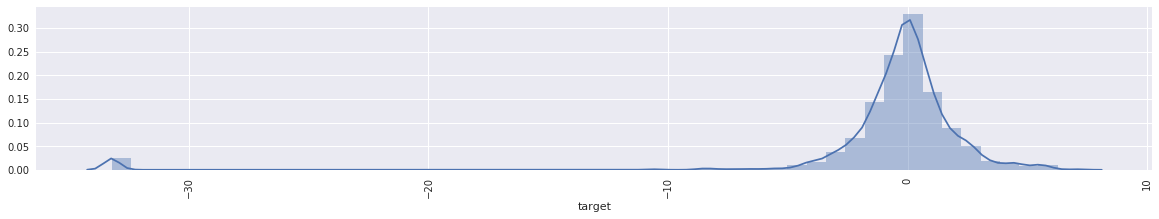

GROUP 54 | CNT: 1327 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-07-01T00:00:00.000000000 | 24
nan nan


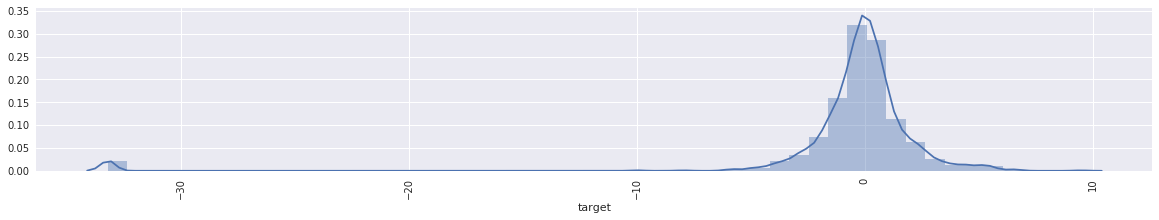

GROUP 60 | CNT: 1255 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-08-01T00:00:00.000000000 | 24
nan nan


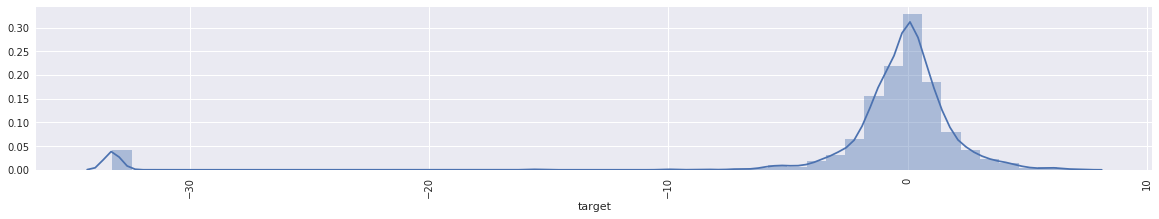

GROUP 67 | CNT: 1267 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-09-01T00:00:00.000000000 | 24
nan nan


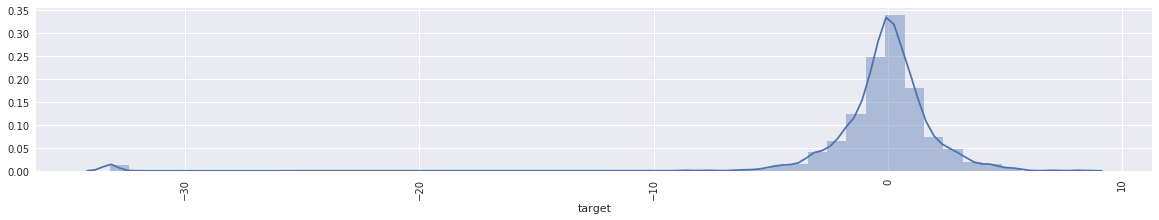

GROUP 75 | CNT: 1302 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-10-01T00:00:00.000000000 | 24
nan nan


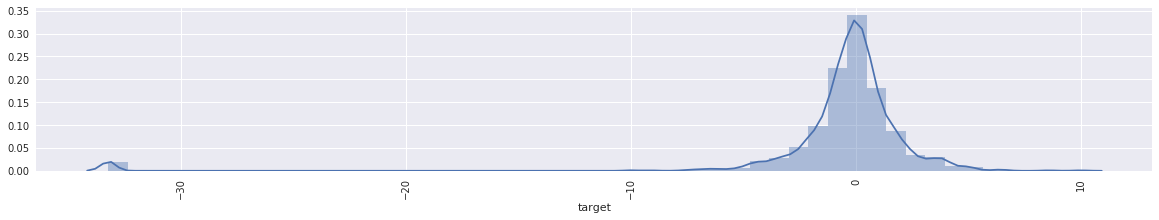

GROUP 84 | CNT: 1311 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-11-01T00:00:00.000000000 | 24
nan nan


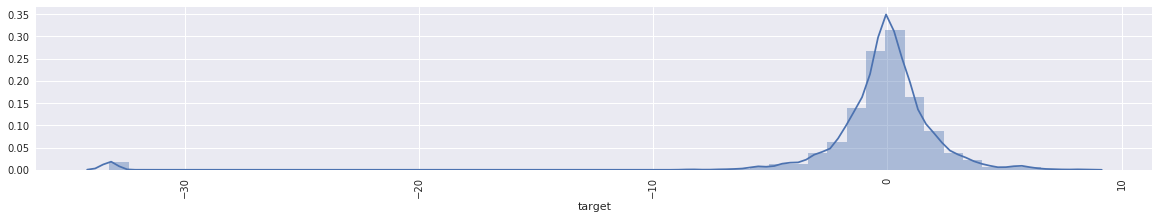

GROUP 94 | CNT: 1874 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-12-01T00:00:00.000000000 | 24
nan nan


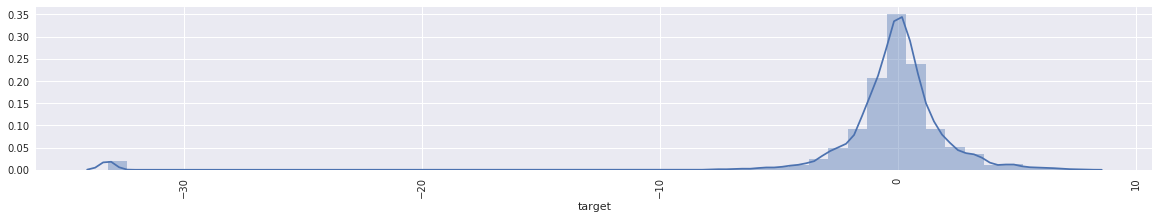

GROUP 105 | CNT: 1242 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-01-01T00:00:00.000000000 | 24
nan nan


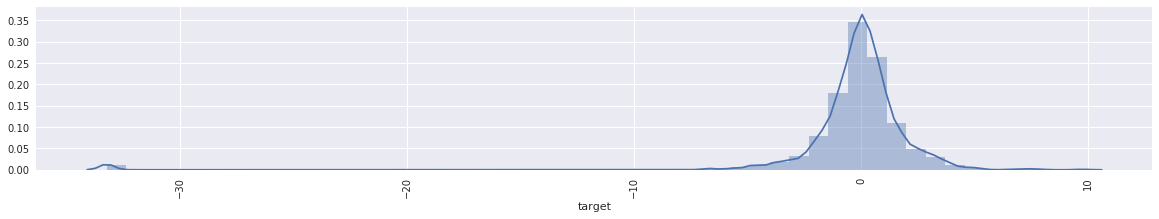

GROUP 117 | CNT: 1032 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-02-01T00:00:00.000000000 | 24
nan nan


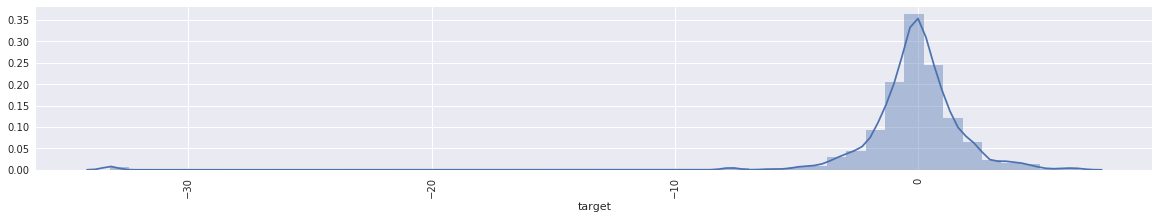

GROUP 130 | CNT: 1094 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-03-01T00:00:00.000000000 | 24
nan nan


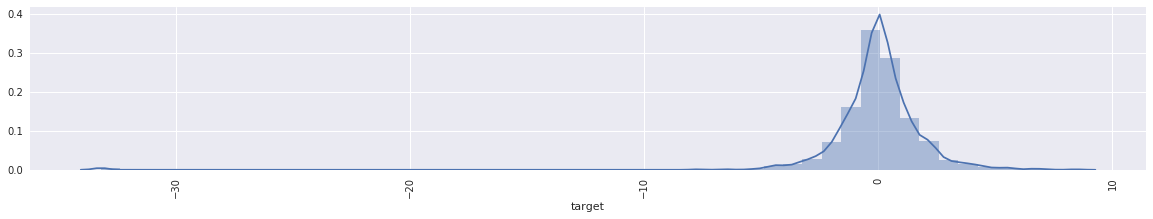

GROUP 143 | CNT: 1614 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-04-01T00:00:00.000000000 | 23
nan nan


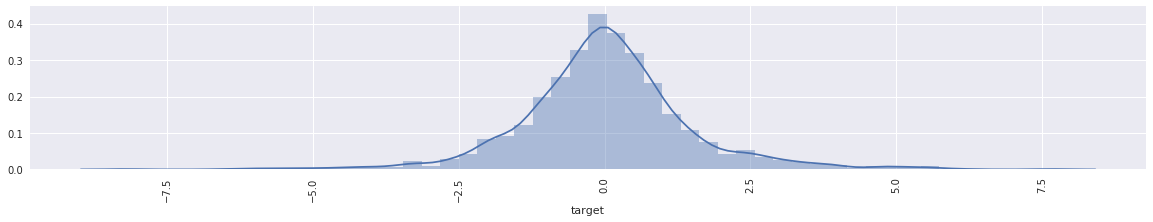

GROUP 156 | CNT: 1790 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-05-01T00:00:00.000000000 | 22
nan nan


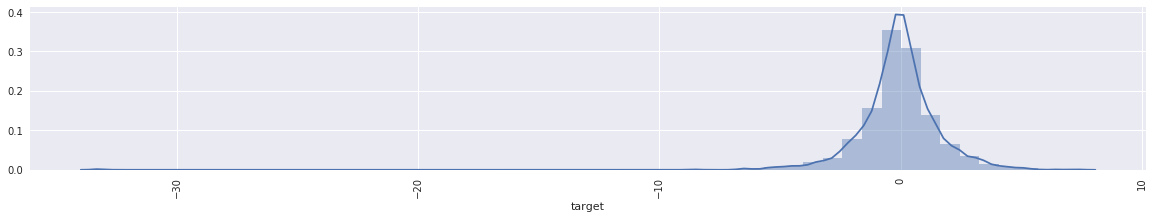

GROUP 169 | CNT: 2223 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-06-01T00:00:00.000000000 | 21
nan nan


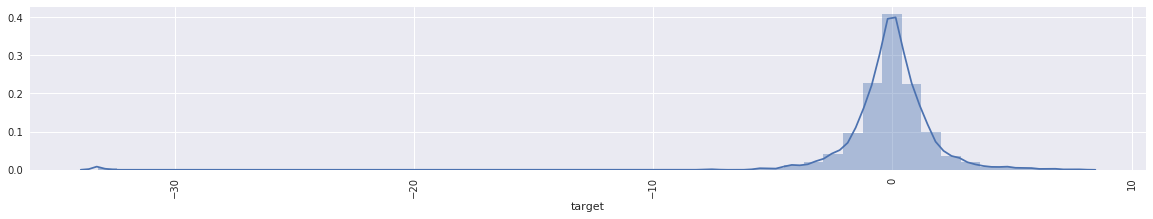

GROUP 182 | CNT: 2282 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-07-01T00:00:00.000000000 | 20
nan nan


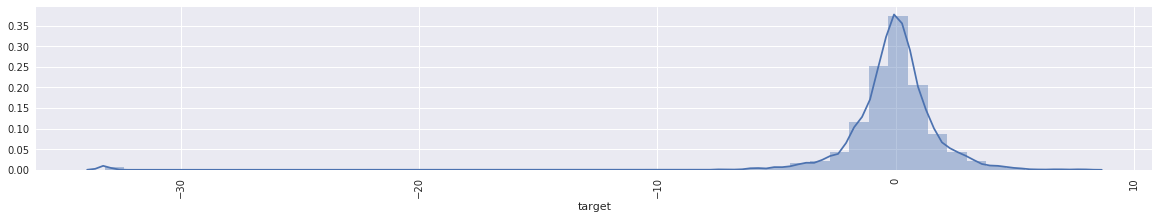

GROUP 195 | CNT: 2784 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-08-01T00:00:00.000000000 | 19
nan nan


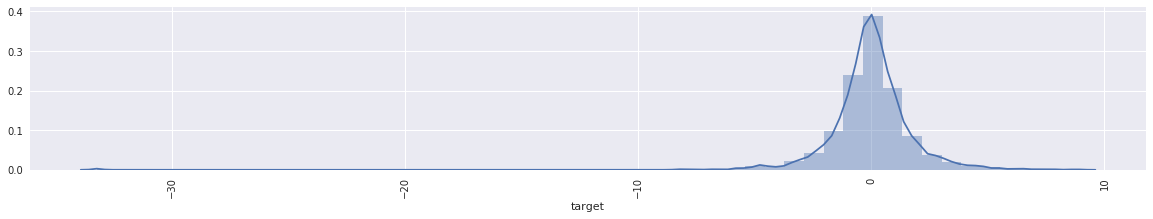

GROUP 208 | CNT: 2352 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-09-01T00:00:00.000000000 | 18
nan nan


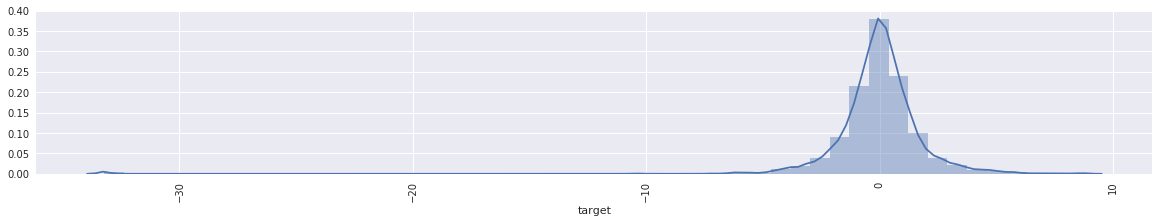

GROUP 221 | CNT: 2949 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-10-01T00:00:00.000000000 | 17
nan nan


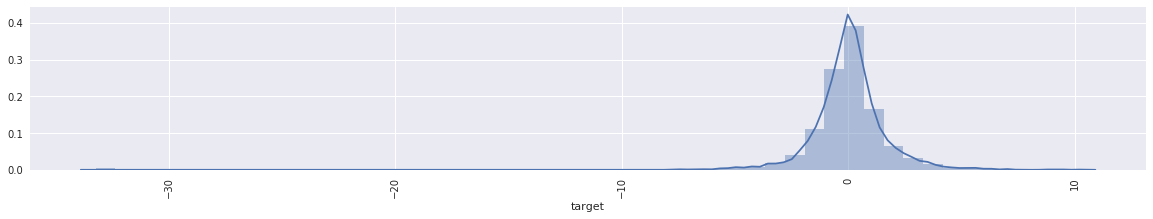

GROUP 234 | CNT: 3873 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-11-01T00:00:00.000000000 | 16
nan nan


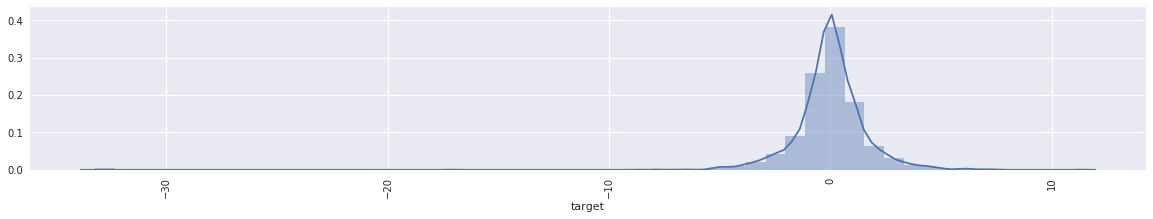

GROUP 246 | CNT: 1078 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-12-01T00:00:00.000000000 | 14
nan nan


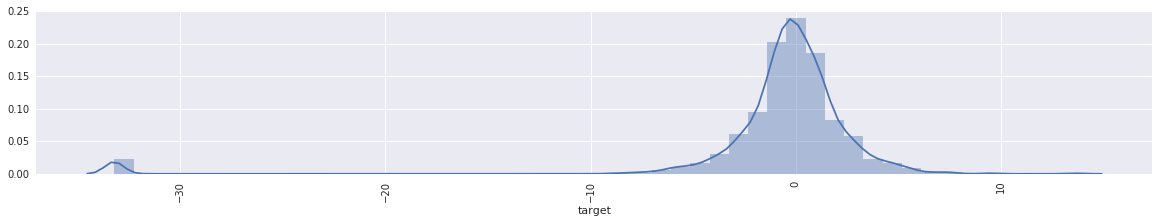

GROUP 247 | CNT: 4921 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-12-01T00:00:00.000000000 | 15
nan nan


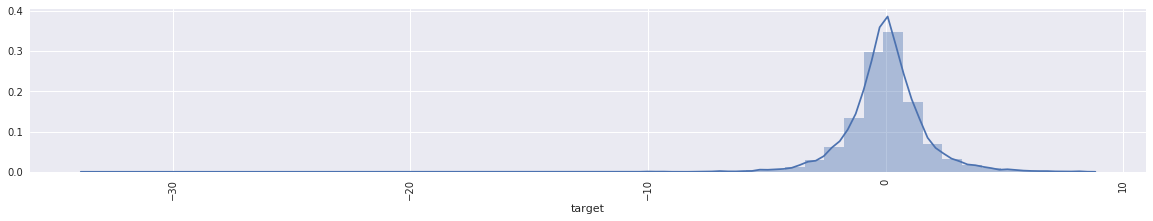

GROUP 259 | CNT: 1039 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-01-01T00:00:00.000000000 | 13
nan nan


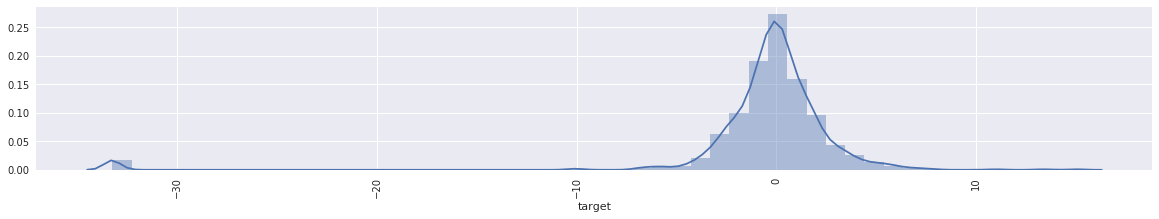

GROUP 260 | CNT: 4911 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-01-01T00:00:00.000000000 | 14
nan nan


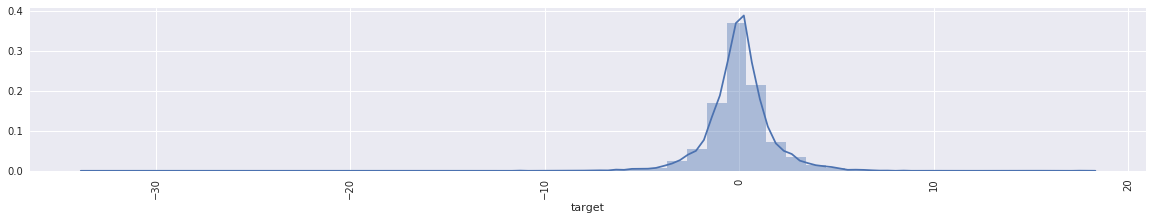

GROUP 272 | CNT: 4209 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-02-01T00:00:00.000000000 | 13
nan nan


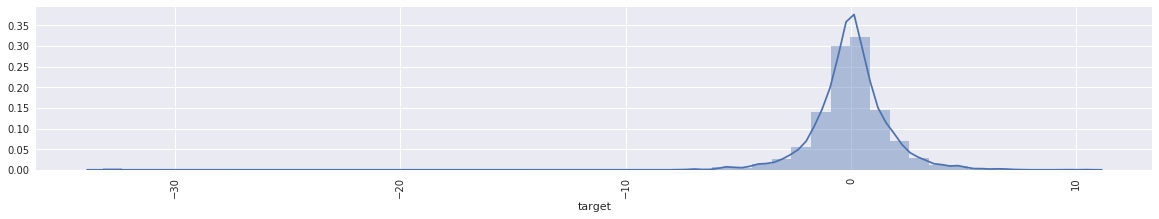

GROUP 283 | CNT: 4379 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-03-01T00:00:00.000000000 | 12
nan nan


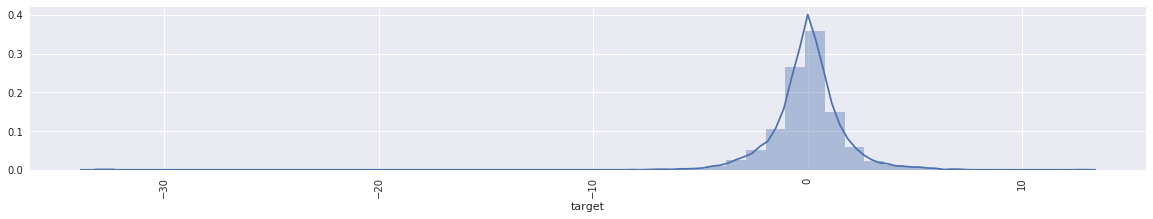

GROUP 294 | CNT: 1046 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-04-01T00:00:00.000000000 | 10
nan nan


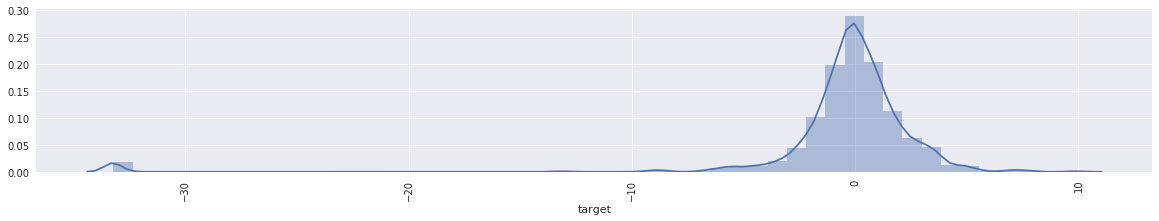

GROUP 295 | CNT: 4930 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-04-01T00:00:00.000000000 | 11
nan nan


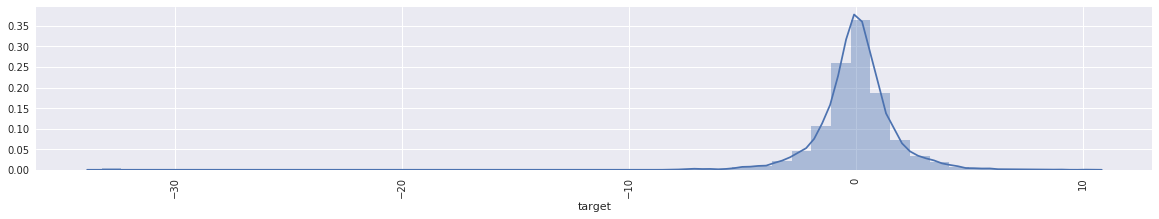

GROUP 304 | CNT: 1114 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-05-01T00:00:00.000000000 | 9
nan nan


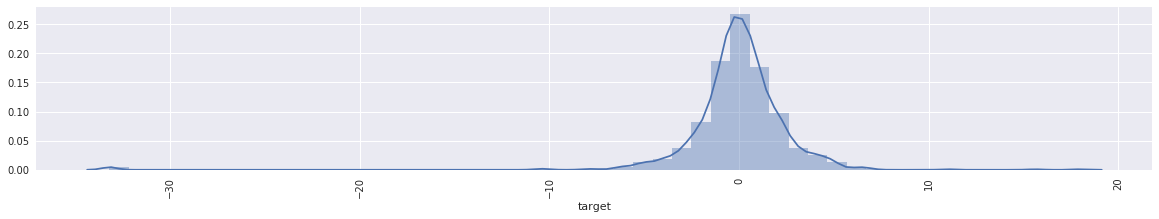

GROUP 305 | CNT: 5409 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-05-01T00:00:00.000000000 | 10
nan nan


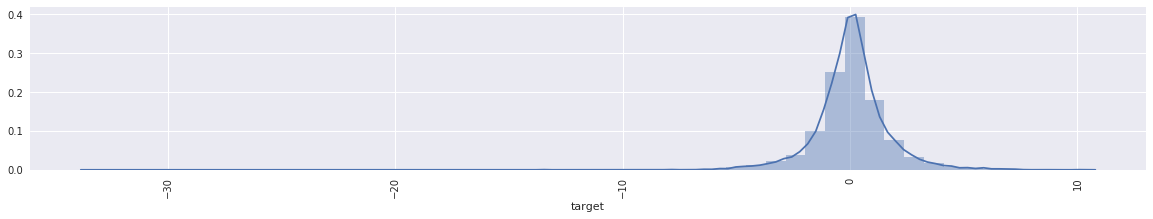

GROUP 313 | CNT: 1314 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-06-01T00:00:00.000000000 | 8
nan nan


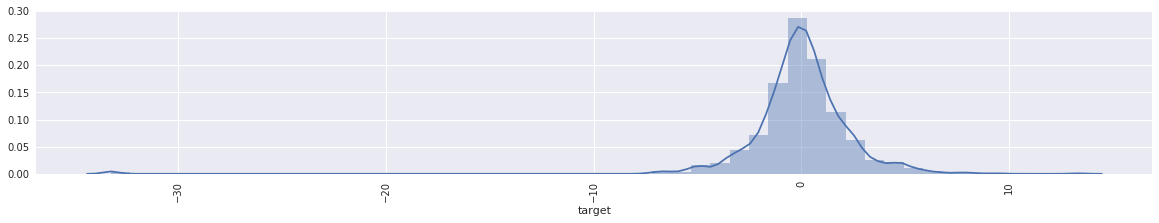

GROUP 314 | CNT: 6101 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-06-01T00:00:00.000000000 | 9
nan nan


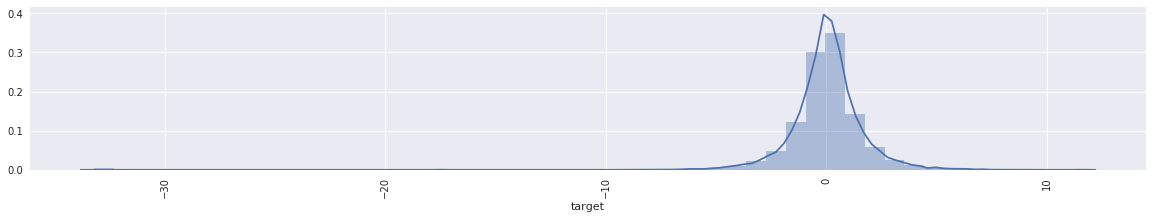

GROUP 320 | CNT: 1098 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 6
nan nan


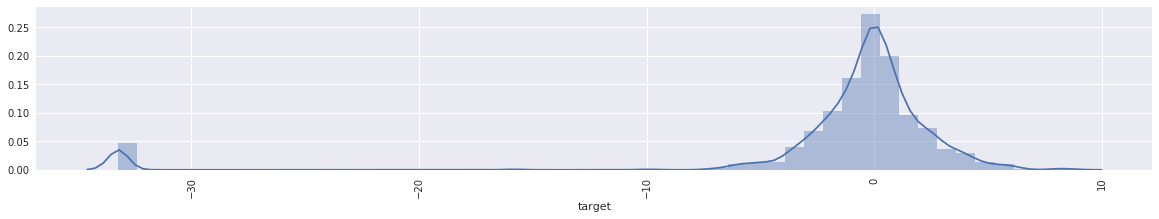

GROUP 321 | CNT: 1701 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 7
nan nan


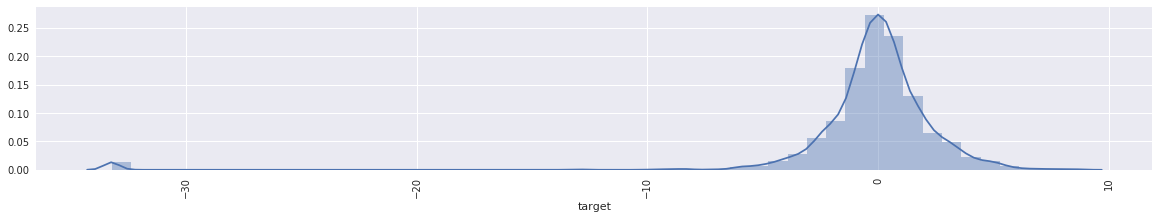

GROUP 322 | CNT: 7980 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 8
nan nan


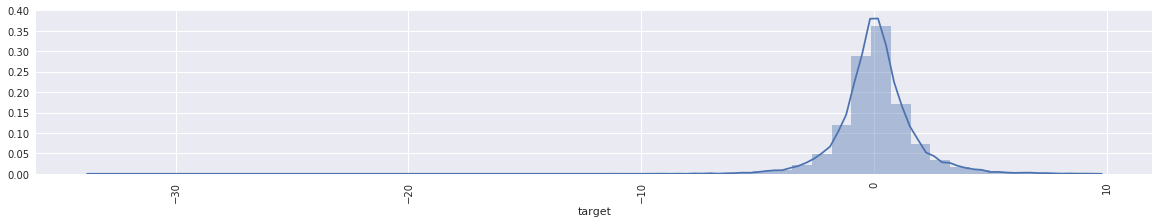

GROUP 326 | CNT: 1172 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 5
nan nan


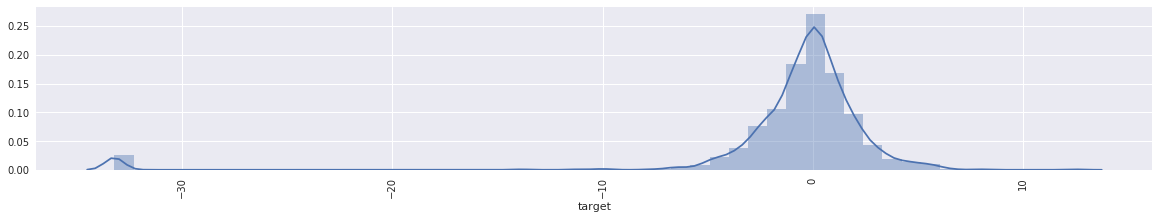

GROUP 327 | CNT: 1822 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 6
nan nan


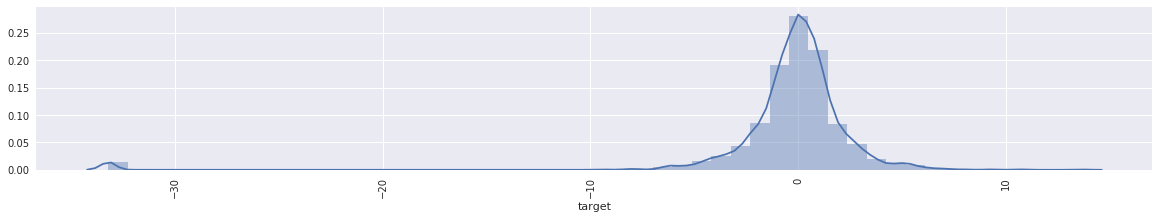

GROUP 328 | CNT: 9420 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 7
nan nan


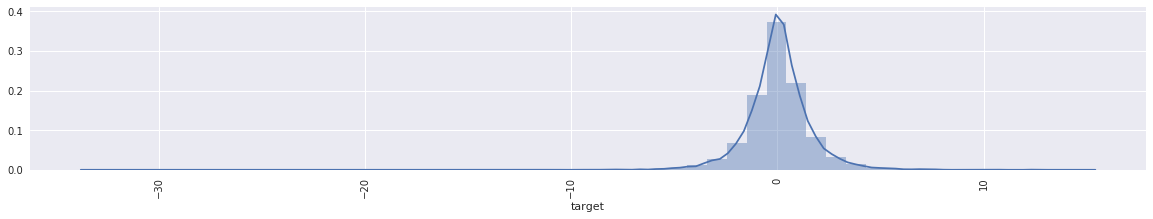

GROUP 332 | CNT: 1139 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 4
nan nan


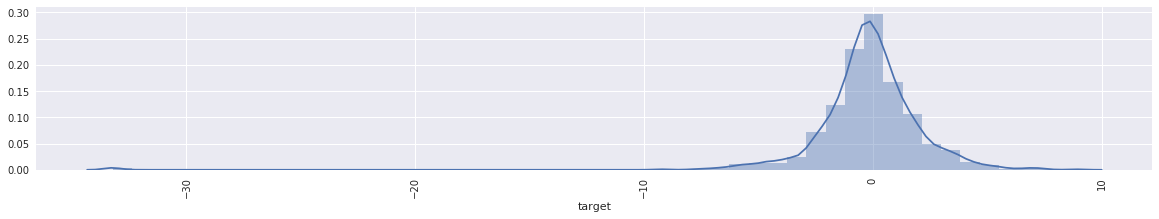

GROUP 333 | CNT: 2036 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 5
nan nan


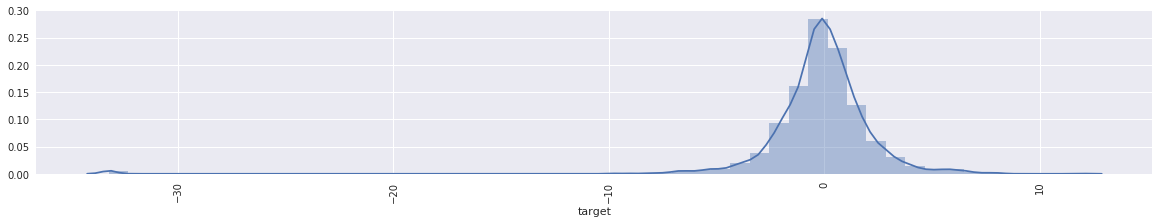

GROUP 334 | CNT: 10105 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 6
nan nan


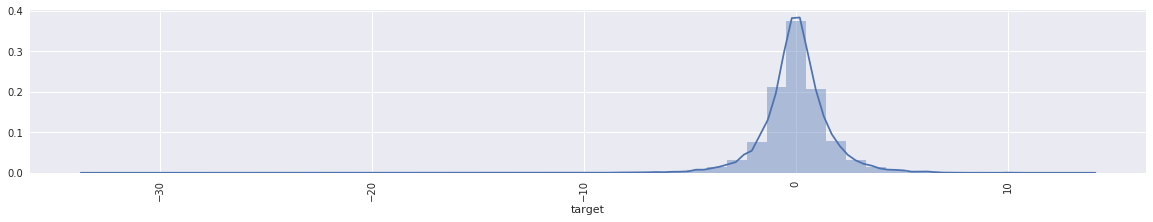

GROUP 337 | CNT: 1960 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-10-01T00:00:00.000000000 | 4
nan nan


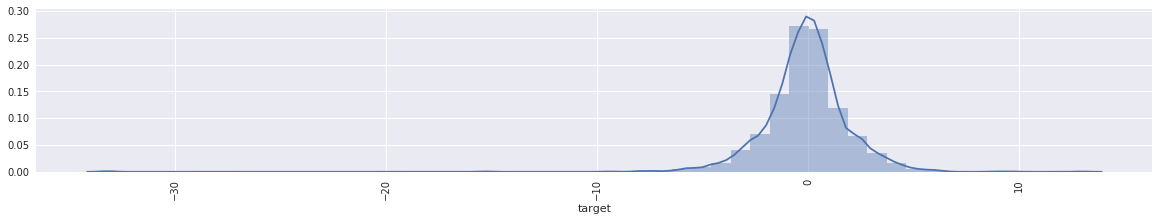

GROUP 338 | CNT: 10759 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-10-01T00:00:00.000000000 | 5
nan nan


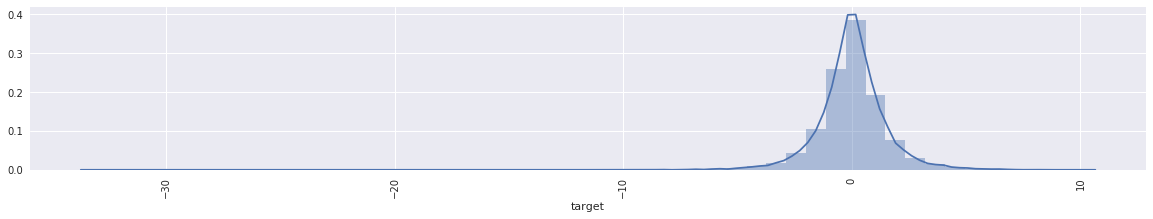

GROUP 341 | CNT: 1538 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-11-01T00:00:00.000000000 | 3
nan nan


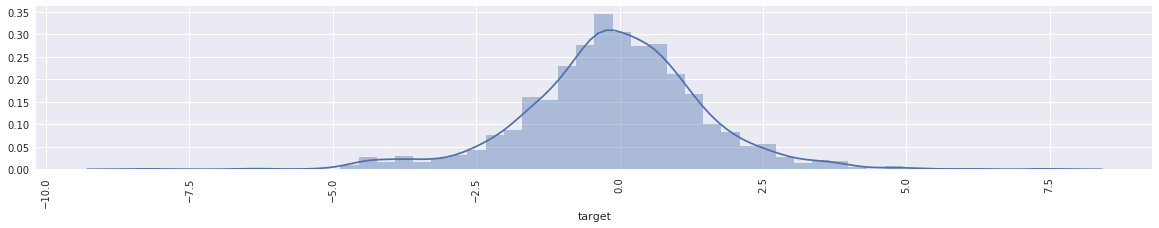

GROUP 342 | CNT: 11166 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-11-01T00:00:00.000000000 | 4
nan nan


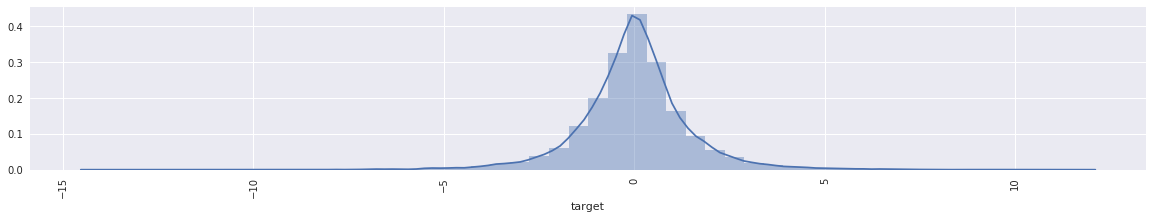

GROUP 345 | CNT: 9939 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-12-01T00:00:00.000000000 | 3
nan nan


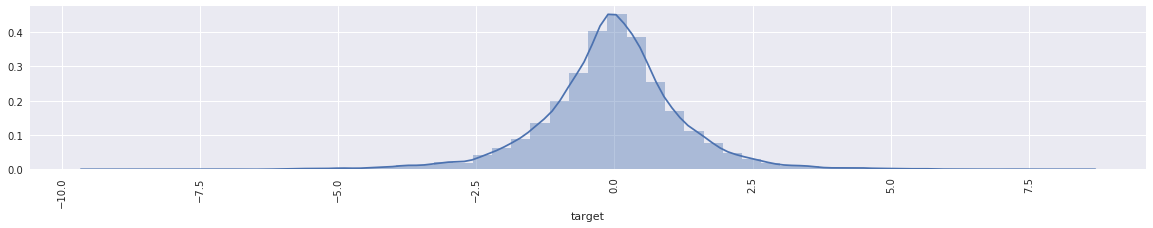

In [26]:
target = 'target'
train_test = utils.read_df_pkl('../input/base_term0*').set_index(key)
fam = 'first_active_month'
fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner')
train = train_test[~train_test[target].isnull()]

train['pred'] = utils.read_pkl_gzip('../stack/0206_125_stack_lgb_lr0.01_235feats_10seed_70leaves_iter1164_OUT29.8269_CV3-6215750935280235_LB.gz').set_index(key)['pred_mean']
target = 'pred'

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# term_list = sorted(list(df_train['hist_regist_term'].value_counts().index))
df = train

group_list = sorted(list(train['group'].value_counts().index))

for i in group_list:
    tmp = df[df['group']==i]
    if len(tmp)<1000:
        continue
    out_cnt = len(tmp[tmp[target]<-30])
    cnt = len(tmp)
    
    print(f"GROUP {i} | CNT: {cnt} | OUTLIER: {out_cnt} | OUT_RATIO: {np.round(out_cnt/cnt, 3)} | {tmp[fam].values[0]} | {tmp[col_term].values[0]}")
    print(tmp[target].max(), tmp[target].min())
    plt.figure(figsize=(20, 3))
    sns.distplot(a=tmp['target'])
    plt.xticks(rotation=90)
    plt.show()